In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
from PIL import Image
import imageio
from google.colab import drive

In [2]:
train = tfds.load('rock_paper_scissors', split='train[:90%]')
valid = tfds.load('rock_paper_scissors', split='train[90%:]')
test = tfds.load('rock_paper_scissors', split='test')

In [3]:
data = tfds.builder('rock_paper_scissors')
info = data.info
info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)

In [4]:
NUM_TRAIN_EXAMPLES = len(train)
NUM_VAL_EXAMPLES = len(valid)
NUM_TEST_EXAMPLES = len(test)
NUM_CLASSES = info.features['label'].num_classes

print('Number of TRAIN examples:', NUM_TRAIN_EXAMPLES)
print('Number of VALID examples:', NUM_VAL_EXAMPLES)
print('Number of TEST examples:', NUM_TEST_EXAMPLES)
print('Number of label classes:', NUM_CLASSES)

Number of TRAIN examples: 2268
Number of VALID examples: 252
Number of TEST examples: 372
Number of label classes: 3


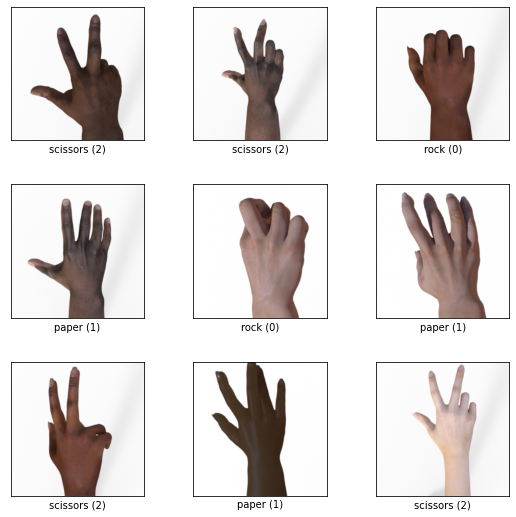

In [5]:
fig = tfds.show_examples(train, info)

In [6]:
train_images = np.array([i["image"].numpy()[:,:,0] for i in train])
train_labels = np.array([i["label"].numpy() for i in train])

valid_images = np.array([i["image"].numpy()[:,:,0] for i in valid])
valid_labels = np.array([i["label"].numpy() for i in valid])

test_images = np.array([i["image"].numpy()[:,:,0] for i in test])
test_labels = np.array([i["label"].numpy() for i in test])

In [7]:
train_images = train_images.reshape(2268, 300, 300, 1)
valid_images = valid_images.reshape(252, 300, 300, 1)
test_images = test_images.reshape(372, 300, 300, 1)

train_images = train_images.astype('float16')
valid_images  =valid_images.astype('float16')
test_images = test_images.astype('float16')

train_images /= 255
valid_images /= 255
test_images /= 255

In [8]:
# Data Augmentation to reduce overfitting and increase generalization

def rand_flip(img):
    image = tf.image.random_flip_left_right(img)
    image = tf.image.random_flip_up_down(image)
    return image

def rand_color(img):
    image = tf.image.random_brightness(img, 0.05)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    return image

def rand_rotation(img):
    image = tf.image.rot90(img, tf.random.uniform(shape=[], minval=1, maxval=4, dtype=tf.int32))
    return image

# Apply the augmentations

for img in train_images:
    img = rand_flip(img)
    img = rand_color(img)
    img = rand_rotation(img)

In [9]:
# Build the Convolutional Neural Network
# Use AveragePooling, MaxPooling, and Dropout to minimize overfitting and generalize better

model = keras.models.Sequential([
        keras.layers.AveragePooling2D(6, 6, input_shape=(300,300,1)),
        keras.layers.Conv2D(64, 3, activation='relu'),
        keras.layers.Conv2D(32, 3, activation='relu'),
        keras.layers.MaxPooling2D(8,8),
        keras.layers.Dropout(0.5),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=5, batch_size=32, 
          validation_data=(valid_images, valid_labels),
          callbacks=keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True))

# Also implement Early Stopping callback 

Epoch 1/5
71/71 [==============================] - 4s 28ms/step - loss: 0.8964 - accuracy: 0.5697 - val_loss: 0.4619 - val_accuracy: 0.8651
Epoch 2/5
71/71 [==============================] - 1s 20ms/step - loss: 0.4041 - accuracy: 0.8457 - val_loss: 0.2067 - val_accuracy: 0.9643
Epoch 3/5
71/71 [==============================] - 1s 20ms/step - loss: 0.2487 - accuracy: 0.9083 - val_loss: 0.1048 - val_accuracy: 0.9881
Epoch 4/5
71/71 [==============================] - 1s 20ms/step - loss: 0.1766 - accuracy: 0.9352 - val_loss: 0.0537 - val_accuracy: 0.9921
Epoch 5/5
71/71 [==============================] - 1s 20ms/step - loss: 0.1317 - accuracy: 0.9541 - val_loss: 0.0580 - val_accuracy: 0.9881


In [10]:
model.evaluate(test_images, test_labels)

# Great accuracy, especially for a small dataset

12/12 [==============================] - 0s 17ms/step - loss: 0.2898 - accuracy: 0.9167


[0.28984203934669495, 0.9166666865348816]

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 average_pooling2d (AverageP  (None, 50, 50, 1)        0         
 ooling2D)                                                       
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 5, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 5, 5, 32)          0         
                                                                 
 flatten (Flatten)           (None, 800)               0

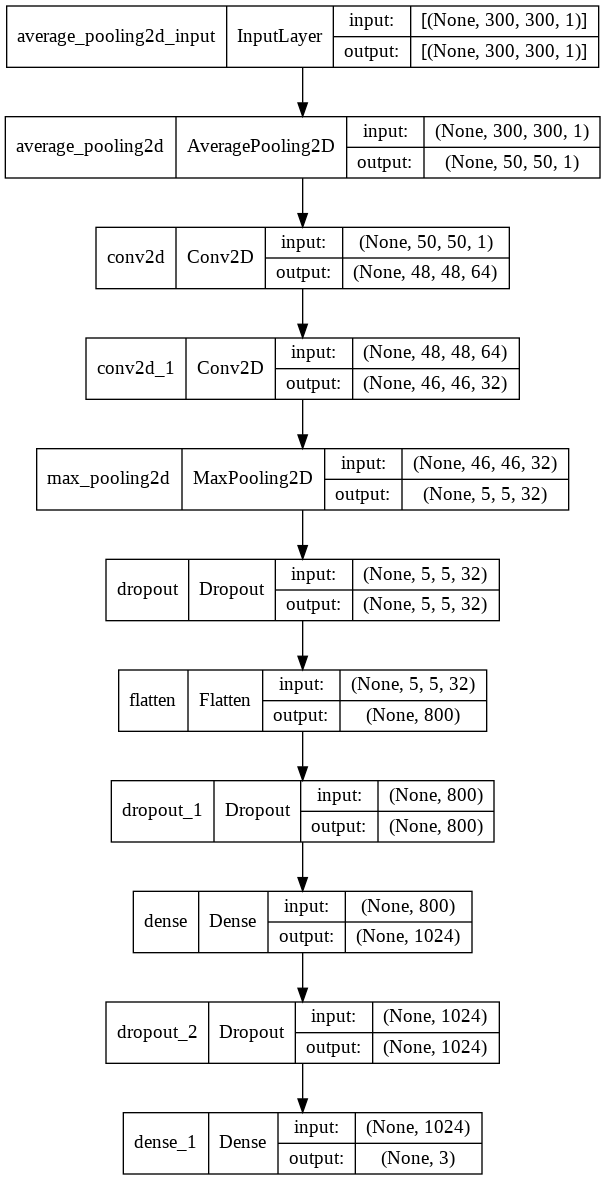

In [12]:
# Visual Representation of the neural network

tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [13]:
# Save the model to Google Drive

drive.mount('/content/gdrive/')

model.save("/content/gdrive/My Drive/model.h5")

Mounted at /content/gdrive/


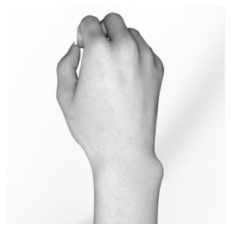

Prediction: 0
Actual label: 0


In [14]:
# Random Manual Prediction

def prediction(img):
  plt.imshow((img*255).astype(np.int).reshape(300,300), cmap='gray')
  plt.axis('off')
  plt.show()
  img = img.reshape(1,300,300,1)
  prediction = model.predict(img)
  print("Prediction:", np.argmax(prediction))

prediction(test_images[100])
print("Actual label:", test_labels[100])

